# Import librerie

In [8]:
import networkx as nx
from networkx.readwrite import json_graph
import random as rand
import json
import numpy as np

import matplotlib.pyplot as plt

import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as cm
import ndlib.models.compartments as cpm

# Classi di utilità
Definizione di un encoder numpy per serializzare i grafi in formato JSON per riutilizzo futuro.\
È stata realizzata per risolvere un problema sulla serializzazione dei grafi restituiti da networkx su alcuni tipi di dati.

In [2]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, ( np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

Classe di utilità che permette la creazione di grafi sintetici secondo modelli random graph, small world o preferential attachment.

In [3]:
class GraphCreator:

    def __init__(self,model_name='random graph',min_nodes=10,max_nodes=100,prob=0.1,label_thresh=0.35):
        self.min_nodes = min_nodes
        self.max_nodes = max_nodes
        self.label_thresh=label_thresh
        self.generation_func = None
        match(model_name):
            case 'random graph':
                self.generation_func= lambda num_nodes :nx.erdos_renyi_graph(num_nodes,prob)
            case 'small world':
                self.generation_func= lambda num_nodes :nx.watts_strogatz_graph(num_nodes,rand.randint(1,num_nodes//2-1),prob)
            case 'preferential attachment':
                self.generation_func= lambda num_nodes :nx.barabasi_albert_graph(num_nodes,rand.randint(1,num_nodes//2-1))
            case 'mixed': # sintetic graph combining small world and preferential attachment
                self.generation_func= lambda num_nodes : GraphCreator._mixed_graph_creation_(num_nodes,prob)
 
    def generate_net(self):
        '''
        Genera un grafo con etichette sui nodi che corrispondono all'etichetta del nodo e ad uno score (tra 0 e 1)
        sulla misinformatività del nodo.
        Returns:
            G (Graph): il grafo generato con nodi etichettati 
        '''
        G = self._generate_graph_net_()
        self._node_label_assignment_(G)
        if len([(u,v) for u,v in G.edges if G.nodes[u]['Misinformative']==1 or G.nodes[v]['Misinformative']==1]) == 0:
            return None
        elif len(G.nodes) == 0:
            return None
        elif len(G.edges)==0:
            return None
        self._edge_weight_(G)
        self._node_features_assignment_(G)
        return G
    
    def _generate_graph_net_(self):
        '''
        Genera la topologia di rete in forma di grafo
        Returns:
            G (Graph): il grafo generato
        '''
        num_nodes = rand.randint(self.min_nodes,self.max_nodes)
        G = self.generation_func(num_nodes)
        return G

    def _mixed_graph_creation_(num_nodes,prob):
        '''
        Costruisce un grafo sintetico come combinazione di un grafo generato da un modello preferential attachment
        e uno generato da un modello small world. La combinazione presenta anche l'aggiunta di archi tra i due grafi per
        garantire la raggiungibilità.
        Args:
            num_nodes (int): numero di nodi che devono avere i grafi generati
            prob (float): la probabilità di rewiring del modello small world
        Returns:
            G (Graph): il grafo combinato
        
        '''
        n1= rand.randint(num_nodes//2,num_nodes-1)
        n2= rand.randint(num_nodes//2,num_nodes-1)
        SW_G= nx.watts_strogatz_graph(n1,rand.randint(1,n1//2-1),prob)
        PA_G= nx.barabasi_albert_graph(n2,rand.randint(1,n2-1))
        return GraphCreator._combine_graphs_(SW_G,PA_G)

    def _combine_graphs_(SW_G,PA_G,k=20,t=0.90):
        '''
        Combina i due grafi aggiungendo k nuovi archi tra coppie di nodi nei due grafi.
        Args:
            SW_G (Graph): grafo generato con modello small world
            PA_G (Graph): grafo generato con modello preferential attachment
            k (int): il numero di archi da aggiungere tra i due grafi
            t (float): probabilità che non si crei un arco tra una coppia di nodi
        Returns:
            G (Graph): il grafo combinato

        '''
        max_sw_id = max(SW_G.nodes())
        pa_node_mapping = {old_id: new_id + max_sw_id + 1 for old_id, new_id in enumerate(PA_G.nodes())}
        PA_G = nx.relabel_nodes(PA_G, pa_node_mapping)
        U = nx.union(SW_G, PA_G)
        to_add = True
        c = 0
        while to_add:
            i = rand.randint(min(SW_G.nodes()),max(SW_G.nodes()))
            j = rand.randint(min(PA_G.nodes()),max(PA_G.nodes()))
            p = rand.uniform(0,1)
            if p > t and not U.has_edge(i,j):
                U.add_edge(i,j)
                c+=1
                if c == k:
                    break
        return U
    
    def _node_label_assignment_alt_(self,G):
        '''
        Assegna ai nodi della rete un attributo "Misinformative" (rappresenta l'etichetta del nodo) in maniera casuale 
        e di un attributo "Score" campionato casualmente da una distribuzione uniforme.
        Args:
            G (Graph): il grafo su cui etichettare i nodi
        '''
        G.nodes(data='True')
        avg_deg = np.mean([val for (_, val) in G.degree()])
        for n in G.nodes:
            score = rand.uniform(0,1)
            if G.degree(n) <= avg_deg:
                thresh = self.label_thresh
            else:
                thresh = self.label_thresh/2
            if score <= (thresh):
                G.nodes[n]['Misinformative'] = 1
                G.nodes[n]['Score'] = rand.uniform(0.6,1)
            else:
                G.nodes[n]['Misinformative'] = 0
                G.nodes[n]['Score'] = rand.uniform(0,4)

    def _node_label_assignment_(self,G,p=1.5):
        '''
        Assegna ai nodi della rete un attributo "Misinformative" (rappresenta l'etichetta del nodo) in maniera casuale 
        e di un attributo "Score" campionato casualmente da una distribuzione di Pareto.
        Args:
            G (Graph): il grafo su cui etichettare i nodi
            p (float): parametro della distribuzione
        '''
        G.nodes(data='True')
        rng = np.random.default_rng()
        samples = rng.pareto(p, len(G.nodes))

        max = np.log(np.max(samples))
        min = np.log(np.min(samples))
        
        x = (np.log(samples)-min)/(max-min)
        x_iter = np.nditer(x)
        for g in G.nodes:
            val = x_iter.__next__()
            if val > self.label_thresh:
                G.nodes[g]['Misinformative'] = 1
            else:
                G.nodes[g]['Misinformative'] = 0
            G.nodes[g]['Score']= val
    
    def _node_features_assignment_(self,G):
        '''
        Assegna ai nodi della rete gli attributi per il numero di condivisioni e like ricevuti.
        Args:
            G (Graph): il grafo su cui aggiungere gli attributi
        '''
        for n in G.nodes:
            c = 0 #count for interactions
            for e in G.edges(n):
                i,j = e
                c+=G[i][j]['Interactions']

            s_n = 0.02 #portion factor for shares common range 0.5% - 2%
            c_n = 0.01 #portion factor for comments common range 0.5% - 1%
            l_n = 0.05 #portion factor for likes 2% - 10%
            d_n = 0.001225 #portion factor for dislikes 2% - 5% 
       
            if G.nodes[n]['Misinformative'] == 1:
                s_n = s_n ** 2
                c_n = c_n ** 2
                l_n = l_n ** 2
                d_n = d_n ** 0.5

            G.nodes[n]['Visuals']=c
            G.nodes[n]['Shares']=rand.randint(int(c*(s_n/2)),int(c*s_n))
            G.nodes[n]['Comments']=rand.randint(int(c*(c_n/2)),int(c*c_n))
            G.nodes[n]['Likes']=rand.randint(int(c*(l_n/2)),int(c*l_n))
            G.nodes[n]['Dislikes']=rand.randint(int(c*(d_n/2)),int(c*(d_n)))

    def _edge_weight_(self,G,p=5,min=25,max=1000,k=10):
        '''
        Assegna agli archi (u,v) della rete un peso proporzionale al numero di individui nella stessa istanza che hanno
        interagito (interactions) con entrambi i post u e v.
        Args:
            G (Graph): il grafo su cui inserire i pesi sugli archi
            p (float): parametro della distribuzione (higer more skewed)
            min (int): minimo numero di individui nella stessa istanza che hanno interagito sui post
            max (int): massimo numero individui nella stessa istanza che hanno interagito sui post
        '''

        misinform_edges = [(u,v) for u,v in G.edges if G.nodes[u]['Misinformative']==1 or G.nodes[v]['Misinformative']==1] # archi incidenti su un nodo misinformativo
        num_mis = len(misinform_edges)
        num_good = len(G.edges) - num_mis
        
        interactions_mis = GraphCreator._sample_(p,num_mis,min,max,k)
        interactions_good = GraphCreator._sample_(p/5,num_good,min,max,k=k/5)
        
        interactions = np.append(interactions_mis,interactions_good)
        interactions = np.array([interactions])
        total = np.sum(np.log(1+interactions))

        mis_iter = np.nditer(np.array(interactions_mis))
        good_iter = np.nditer(np.array(interactions_good))
        for e in G.edges:
            i,j = e
            tmp = None
            if (G.nodes[i]['Misinformative']==1 or G.nodes[j]['Misinformative']==1):
                tmp = mis_iter.__next__()
            else:
                tmp = good_iter.__next__()
            G[i][j]['Interactions'] = tmp
            G[i][j]['Weight'] = np.log(1+tmp) / total

    def _sample_(p,size,a,b,k):
        '''
        Campiona un numero prefissato (size) di elementi da una distribuzione con parametro p.
        Args:
            p (float): parametro della distribuzione
            size (int): numero di campioni da campionare
            a (int): valore minimimo per i dati campionati da restituire
            b (int): valore massimo per i dati campionati da restituire
            k (float): esponente della trasformazione dei dati finali (higer more skewed)
        Return:
            x (list[int]): campioni
        '''
        rng = np.random.default_rng()
        samples = rng.pareto(p, size)

        max = np.log(np.max(samples))
        min = np.log(np.min(samples))
        
        x = (np.log(samples)-min)/(max-min) +1e-3 #normalize in a range [0,1]
        x=a+(x**k)*(b-a) #apply transform
        return x.astype(int)
    
    def to_json(G):
        '''
        Restituisce la rapresentazione in formato JSON di un grafo.
        Args:
            G (Graph): il grafo per cui si vuole la rappresentazione JSON
        Returns:
            Json (str): rappresentazione JSON del grafo
        '''
        return  nx.node_link_data(G)
    

# Metodi di utilità
Metodi che sevono a caricare e salvare i grafi sintetici.

In [5]:
def write_to_json(GS,path='out.json'):
    data = []
    for g in GS:
        data.append(GraphCreator.to_json(g))
    with open(path,'w') as file:
        json.dump(data, file, indent=4, sort_keys=True,separators=(', ', ': '), ensure_ascii=False,cls=NumpyEncoder)
        file.close()

def read_from_json(path='out.json'):
    json_gs= None
    with open(path,'r') as file:
        json_gs = json.load(file)
        file.close()
    GS = []
    for G in json_gs:
        GS.append(json_graph.node_link_graph(G))
    return GS

# Generazione grafi con small world
Creiamo preliminarmente un grafo small world e lo salvo su un file JSON.

In [6]:
gc = GraphCreator(min_nodes=200,max_nodes=370,model_name='small world',prob=0.8,label_thresh=0.70)
GS = []
k = 100
for i in range(k):
    g = gc.generate_net()
    if g!=None:
        GS.append(g)
write_to_json(GS,path='small world net.json')

KeyboardInterrupt: 

# Generazione grafi con preferential attachment
Creiamo preliminarmente un grafo preferential attachment e lo salvo su un file JSON.

In [ ]:
gc = GraphCreator(min_nodes=250,max_nodes=350,model_name='preferential attachment',label_thresh=0.7)
GS = []
k = 250
for i in range(k):
    g = gc.generate_net()
    if g!=None:
        GS.append(g)
write_to_json(GS,path='preferential attachment net.json')

# Generazione grafi misti small world e preferential attachment

In [ ]:
gc = GraphCreator(min_nodes=50,max_nodes=350,model_name='mixed',prob=0.8,label_thresh=0.7)
GS = []
k = 1
for i in range(k):
    g = gc.generate_net()
    if g!=None:
        GS.append(g)
write_to_json(GS,path='mixed net.json')

7226


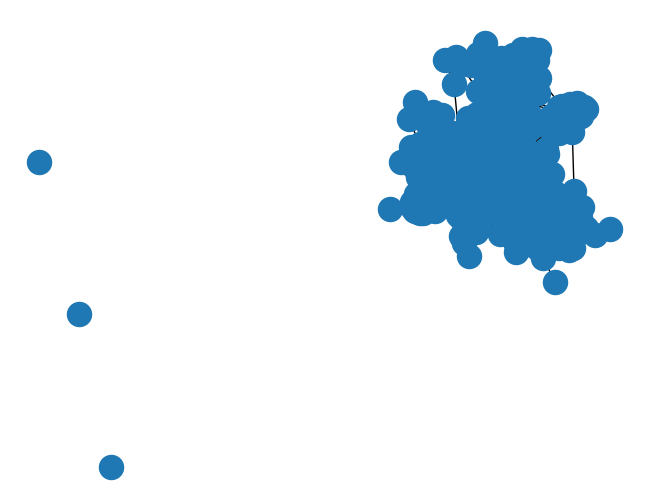

In [ ]:
nx.draw(GS[1])